# 0. Package

In [4]:
library(sarima)
library(ggplot2)
library(forecast)
library(data.table)
library(gridExtra)
library(fUnitRoots)
library(portes)
library(lmtest)

## Intro : ARIMA(0,0,0)(0,0,1)_12 : SMA(1)

$$ ARIMA(0,0,0)(0,0,1)_{12} =SMA(1)= Z_t = (1-\theta B^{12})\varepsilon_t$$

In [9]:
setwd("C:\\Users\\lee\\Desktop\\고급시계열 분석\\제5판_시계열분석_프로그램\\제5판 시계열분석 data")

In [10]:
options(repr.plot.res=200,repr.plot.width=10,repr.plot.height=6)

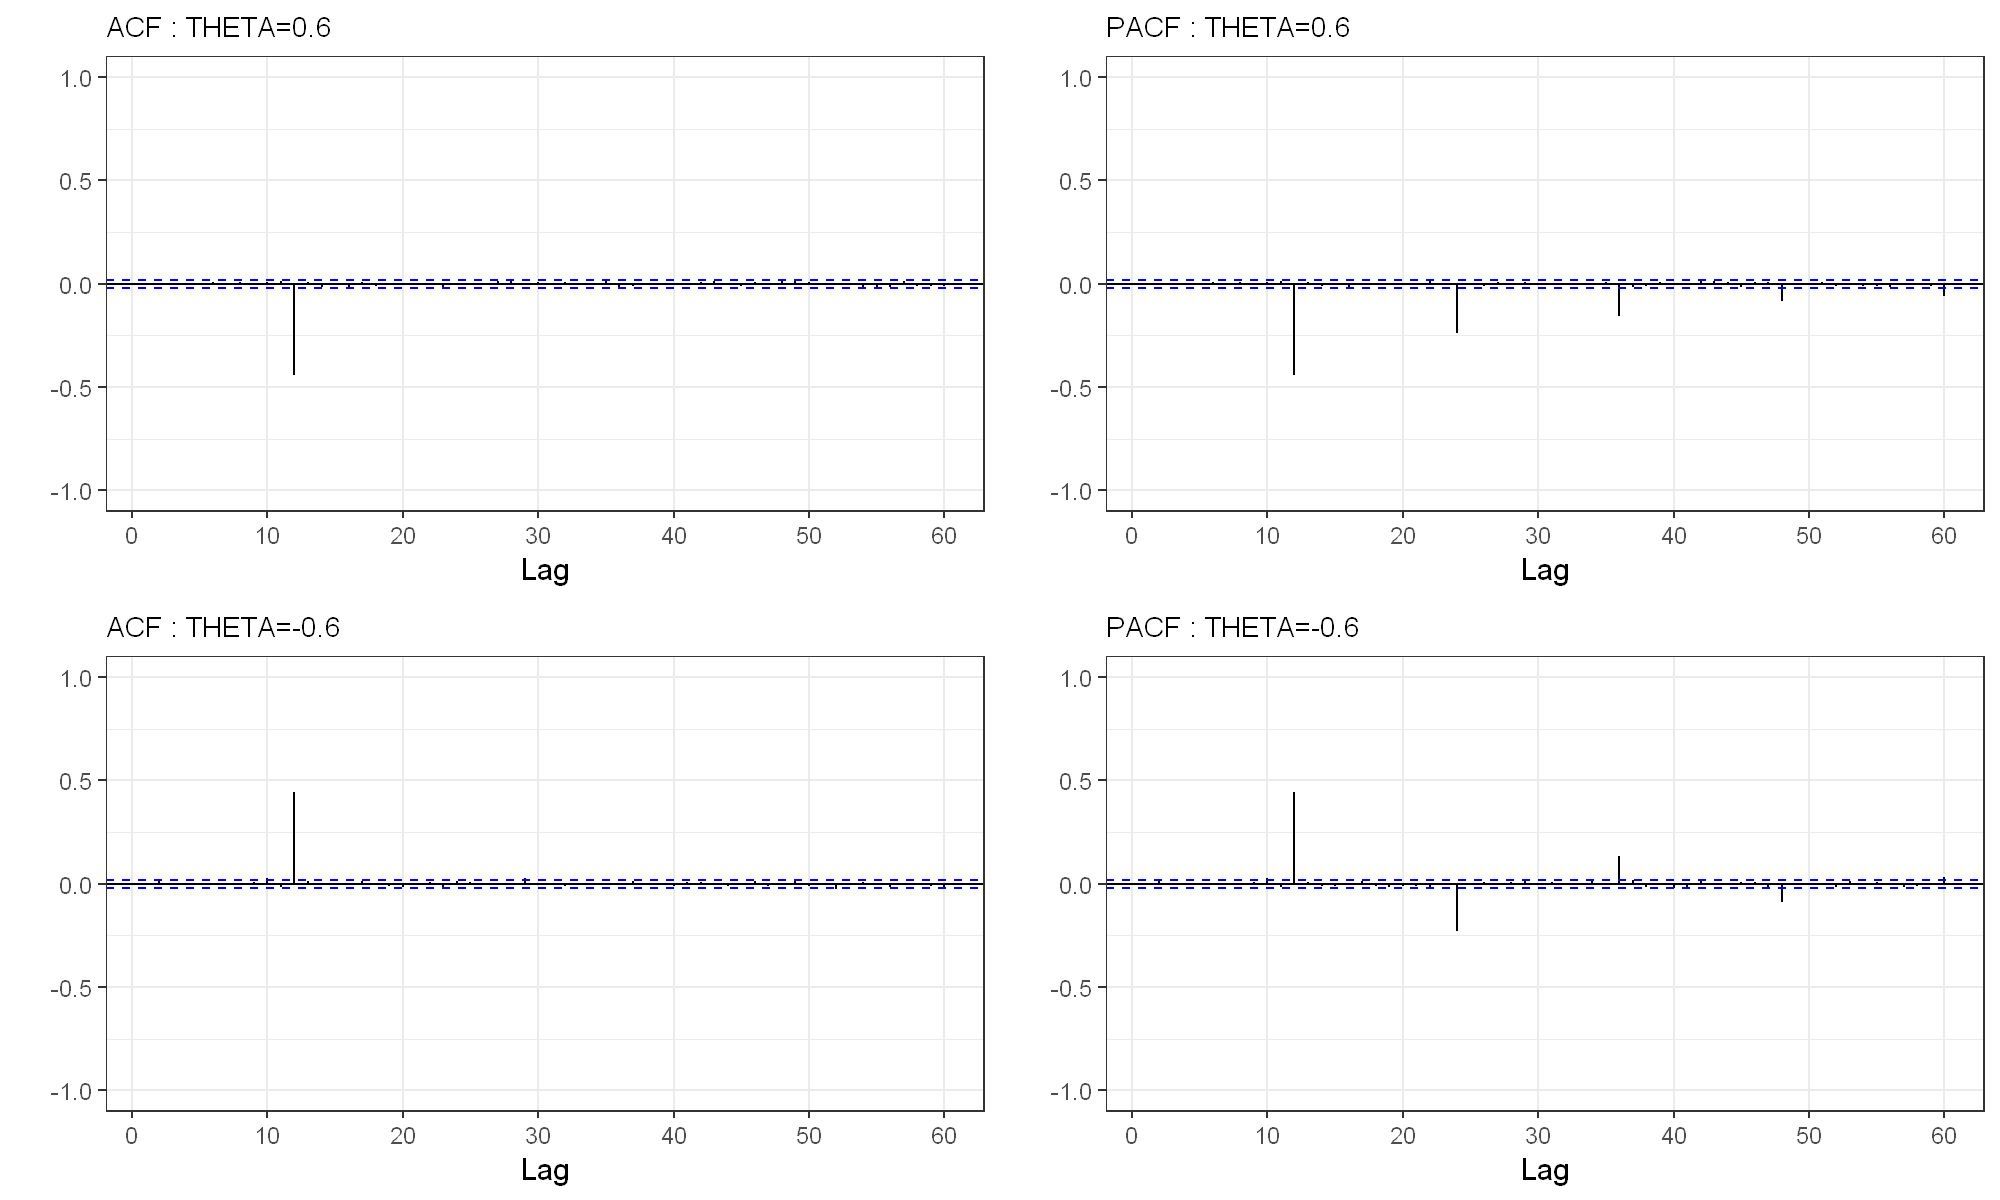

In [14]:
x <- sim_sarima(n=10000,
                model=list(sma=-0.6, nseasons=12, sigma2 = 1)) # SMA(1)
y <- sim_sarima(n=10000,
                model=list(sma=0.6, nseasons=12, sigma2 = 1)) # SMA(1)

p1 <- ggAcf(x, lag.max=60) + ylab("") +  
  theme_bw() + ylim(-1,1) + ggtitle('ACF : THETA=0.6') + 
  theme(plot.title = element_text(size=10))

p2 <- ggPacf(x, lag.max=60) + ylab("") +
  theme_bw() +ylim(-1,1)  + ggtitle('PACF : THETA=0.6')+ 
  theme(plot.title = element_text(size=10))

p3 <- ggAcf(y, lag.max=60) + ylab("") +
  theme_bw() + ylim(-1,1) + ggtitle('ACF : THETA=-0.6')+ 
  theme(plot.title = element_text(size=10))

p4 <- ggPacf(y, lag.max=60) + ylab("") +
  theme_bw() +ylim(-1,1) + ggtitle('PACF : THETA=-0.6')+ 
  theme(plot.title = element_text(size=10))


grid.arrange(p1, p2, p3, p4, nrow=2)

* 주기가  12인 $SMA(1)$ 모형이므로  acf값을 보면 12차수에서 절단인 값을 볼 수 있다.

* pacf는 지수적으로 감소하고 있는 것을 알 수 있다.

* 모형 적합시 한 가지 모형만 고려할 필요는 없음 시도표, acf, pacf 절단값을 보고 다양한 모형 중에서 적절한 근거를 통해 선정할 수 있다.

## 예제 10.2

In [16]:
tour <- scan("tourist.txt")

dt <- data.table(t = 1:length(tour),
                 z = tour)

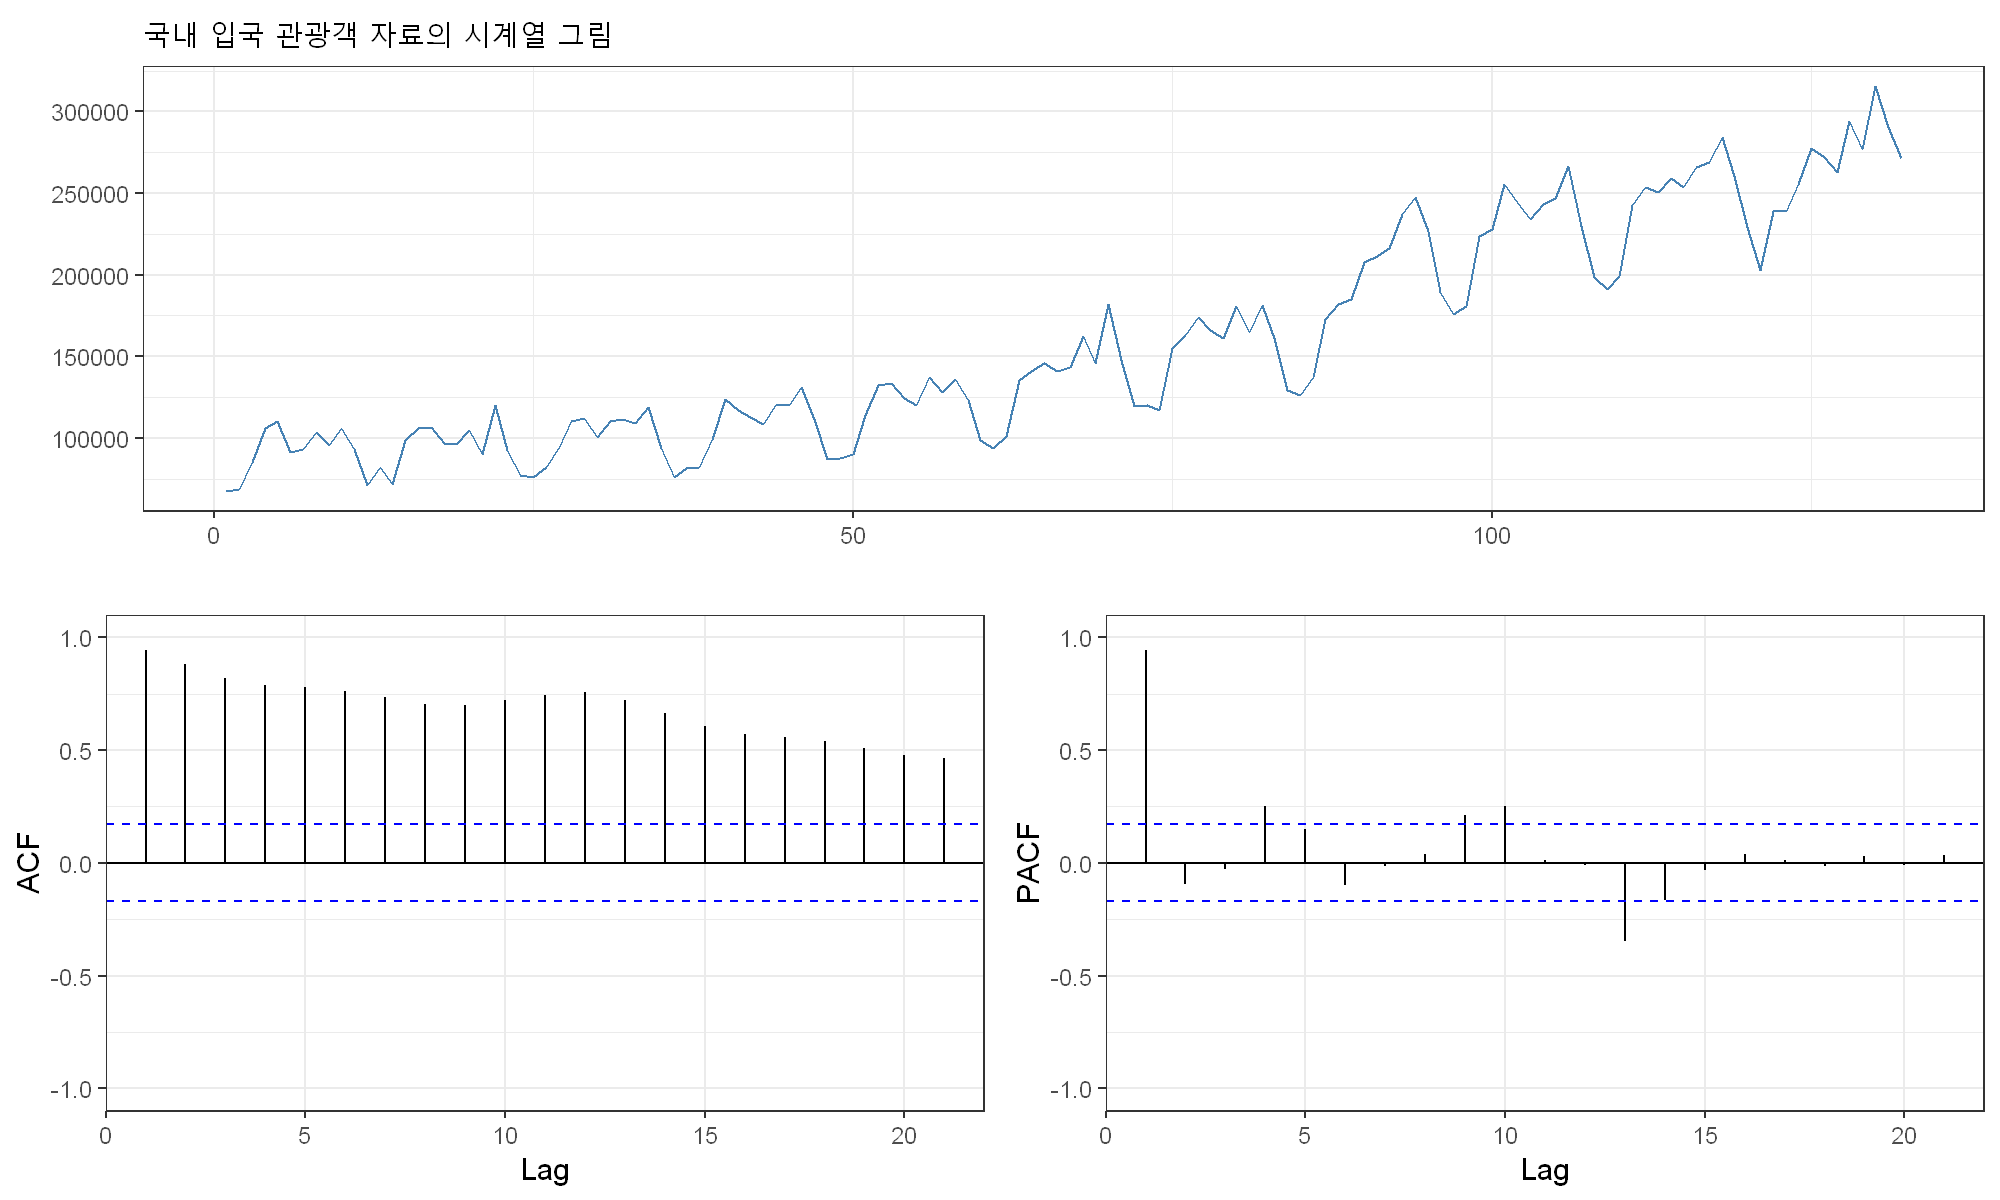

In [17]:
p3 <- ggplot(dt, aes(t, z)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('국내 입국 관광객 자료의 시계열 그림')+
  theme_bw()

p1 <- ggAcf(dt$z) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(dt$z) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

* 시도표를 그린 결과 분산 안정화가 필요해 보임

* 로그변환, sqrt 변환, box-cox변환을 이용해 변환 후 비교

In [19]:
dt[, lnz := log(z)]
dt[, sqrtz := sqrt(z)]
dt[, boxcoxz := BoxCox(z,lambda= BoxCox.lambda(z))]

### 분산 안정화 변환 후 비교

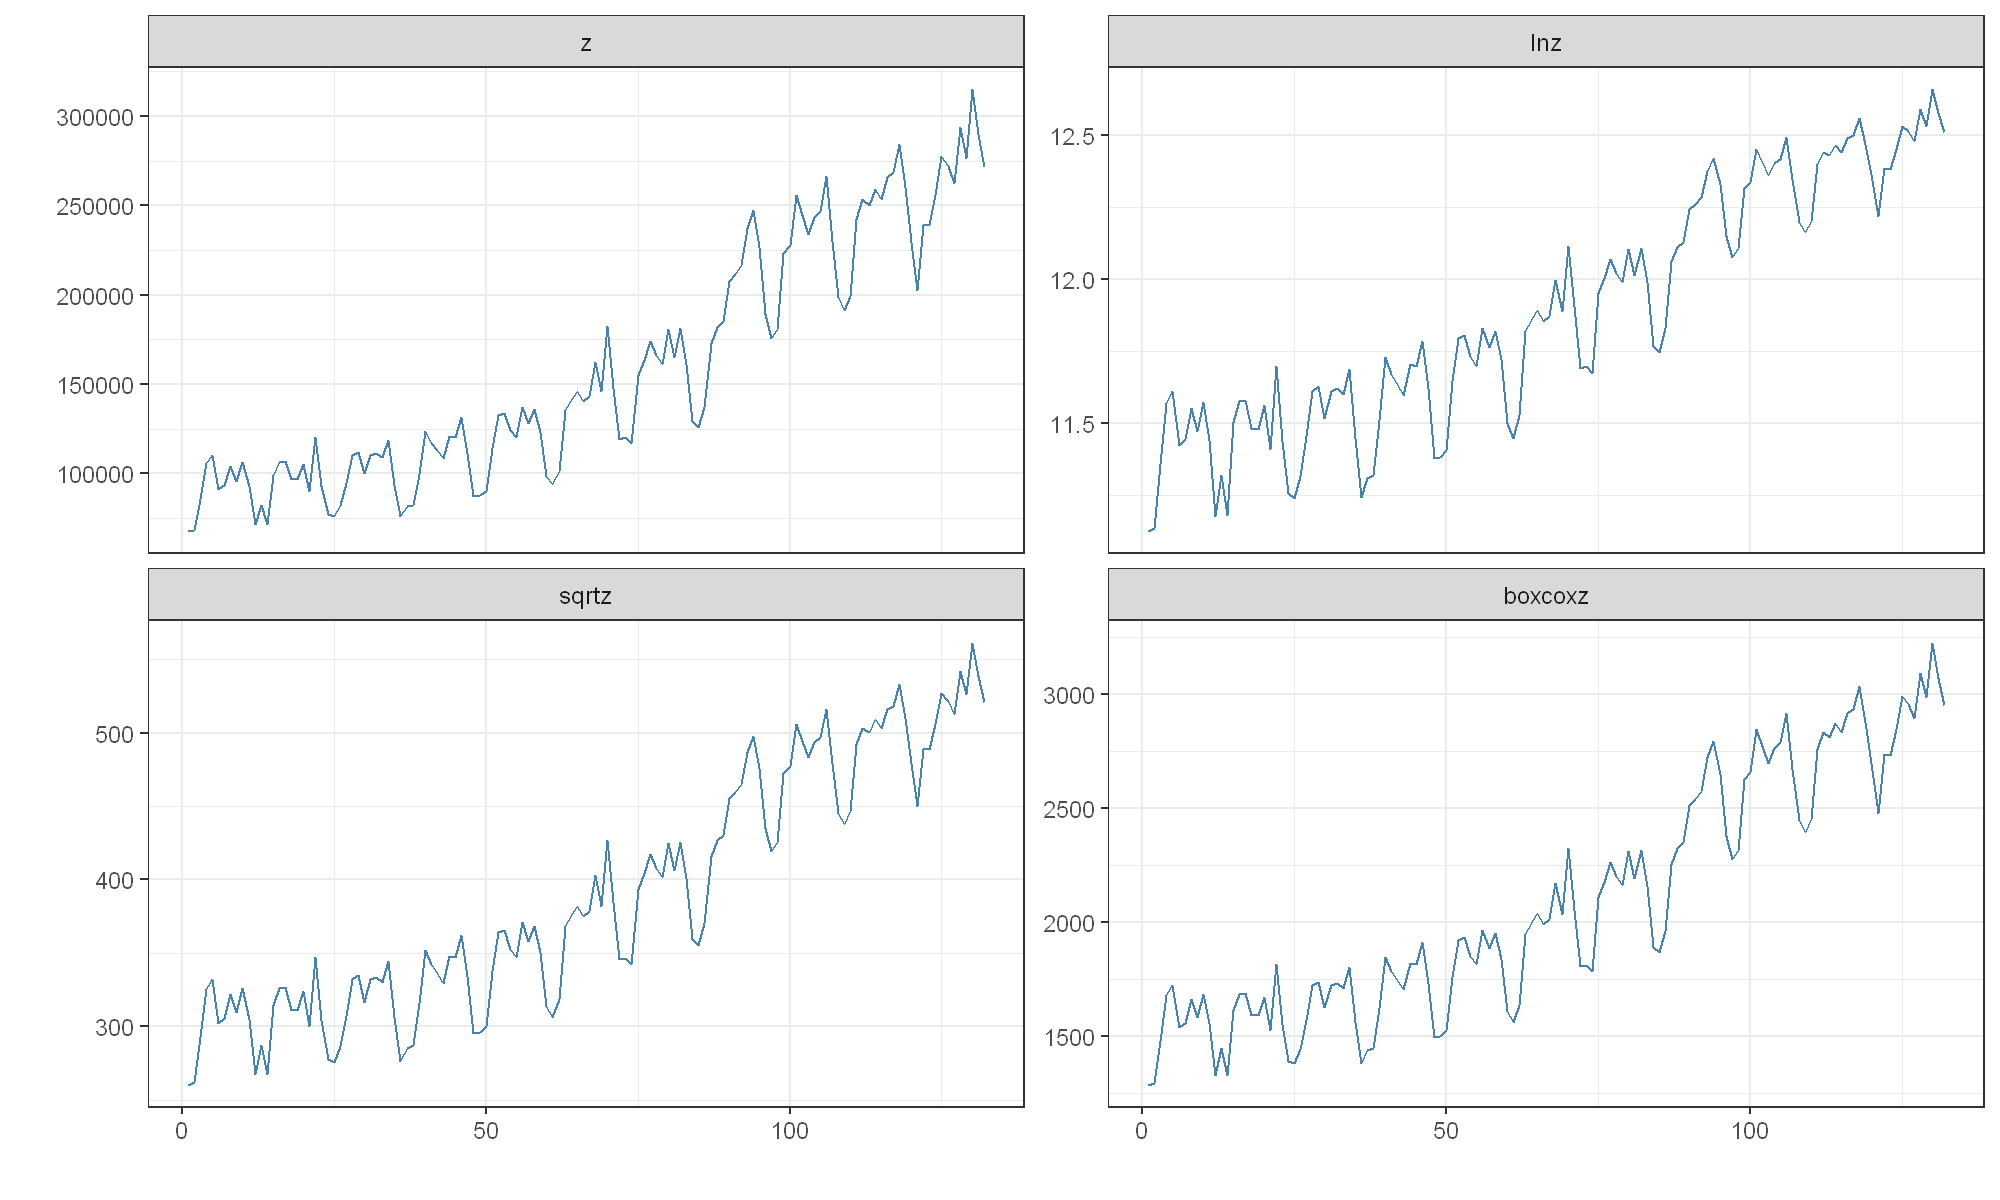

In [20]:
melt.dt <- melt(dt, id=1)
ggplot(melt.dt, aes(t, value)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ 
  facet_wrap(variable~.,nrow=2, scales = "free_y")+
  theme_bw()

* 비교 결과 : sqrt를 이용하여 하는 것이 바람직하다는 생각이 드나 책에서는 로그변환을 하였으므로 절차를 따르자

### 로그변환 후 시도표, ACF, PACF

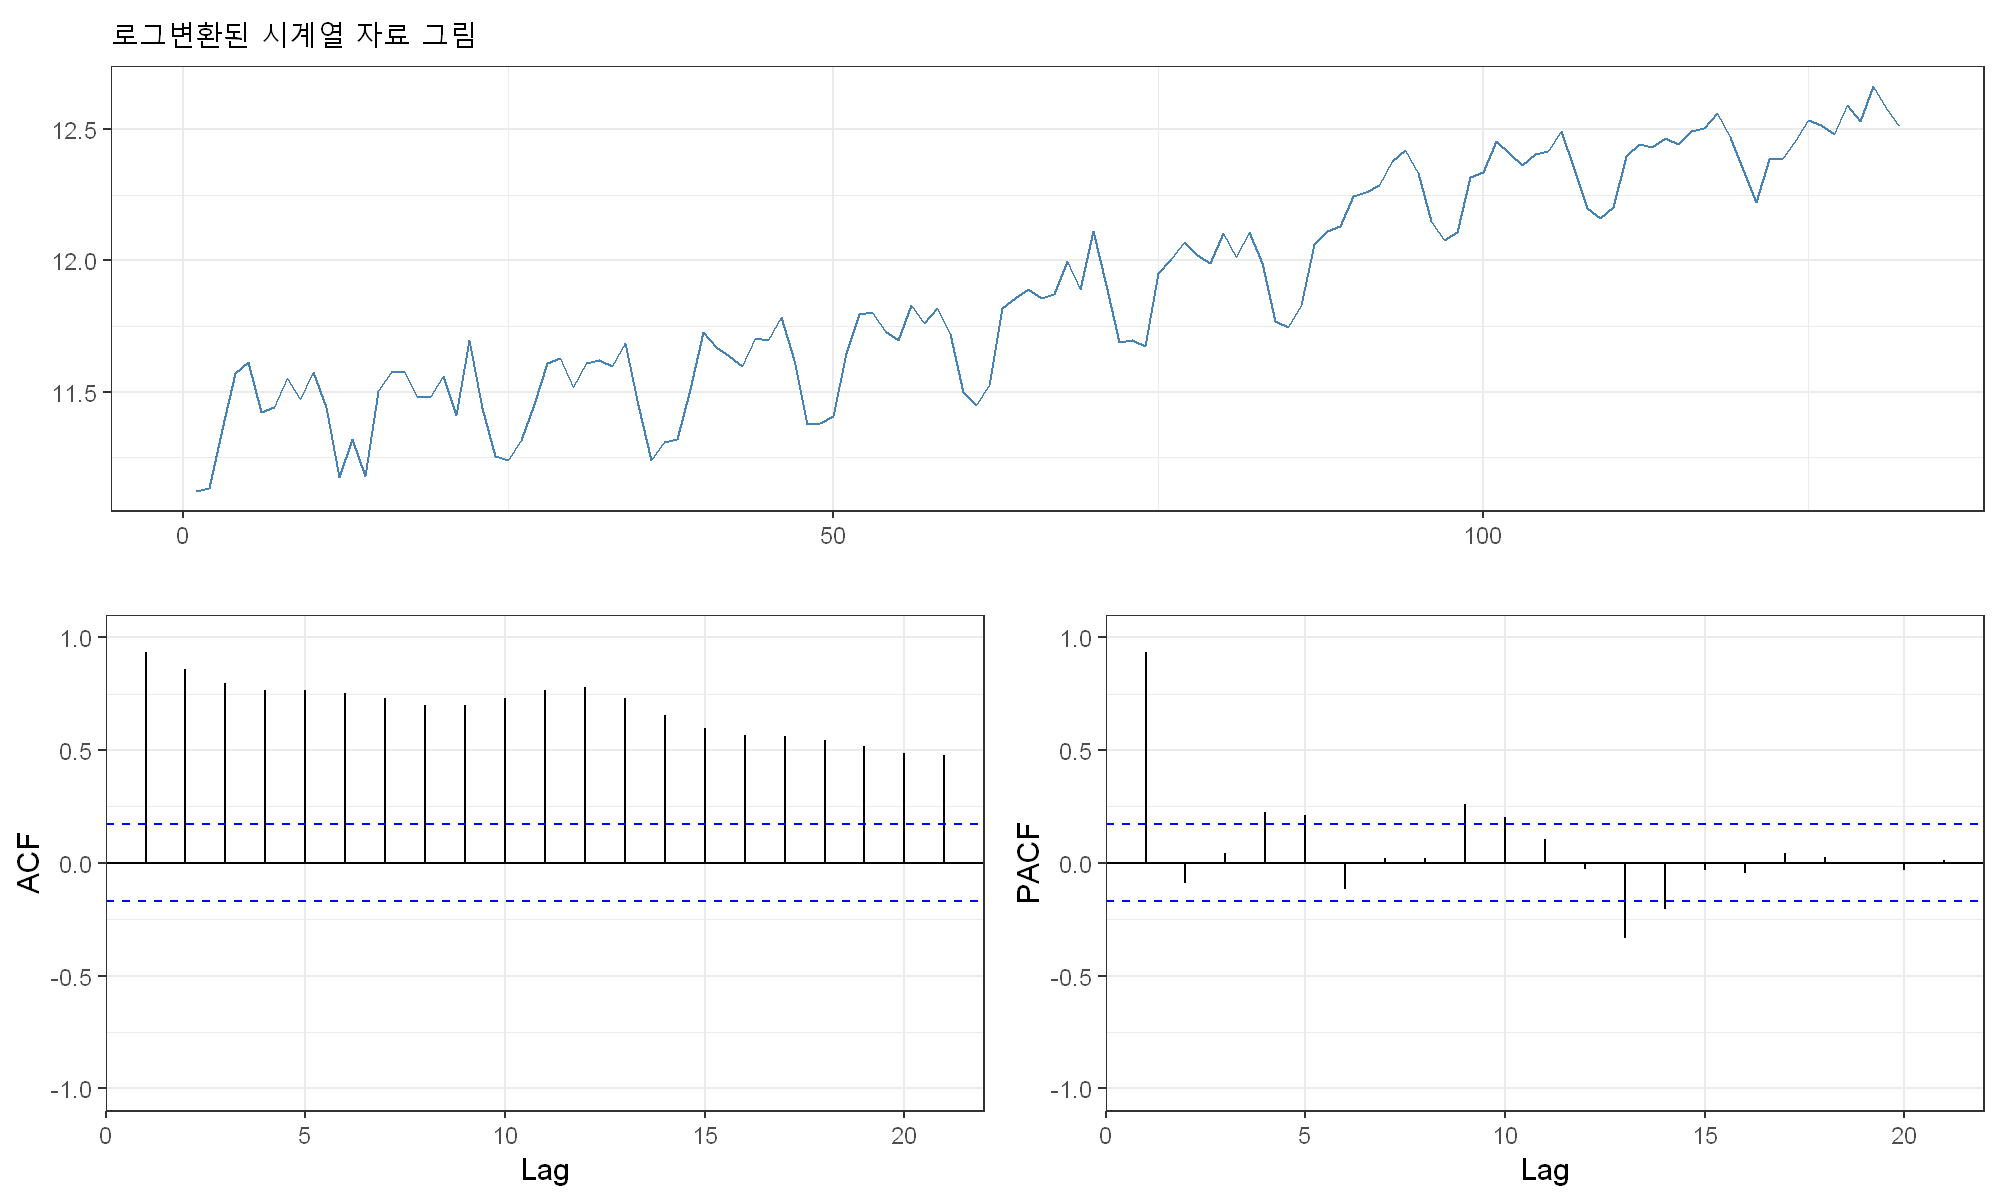

In [21]:
p3 <- ggplot(dt, aes(t, lnz)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('로그변환된 시계열 자료 그림')+
  theme_bw()

p1 <- ggAcf(dt$lnz) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(dt$lnz) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

* 시도표에서 계절성분과 추세성분이 관측되었다.

* 또한 ACF를 보면 지수적으로 감소하는 경향이 보이는데 계절성분을 가지고 있기 때문에 아래와 같은 형태를 지닌다.

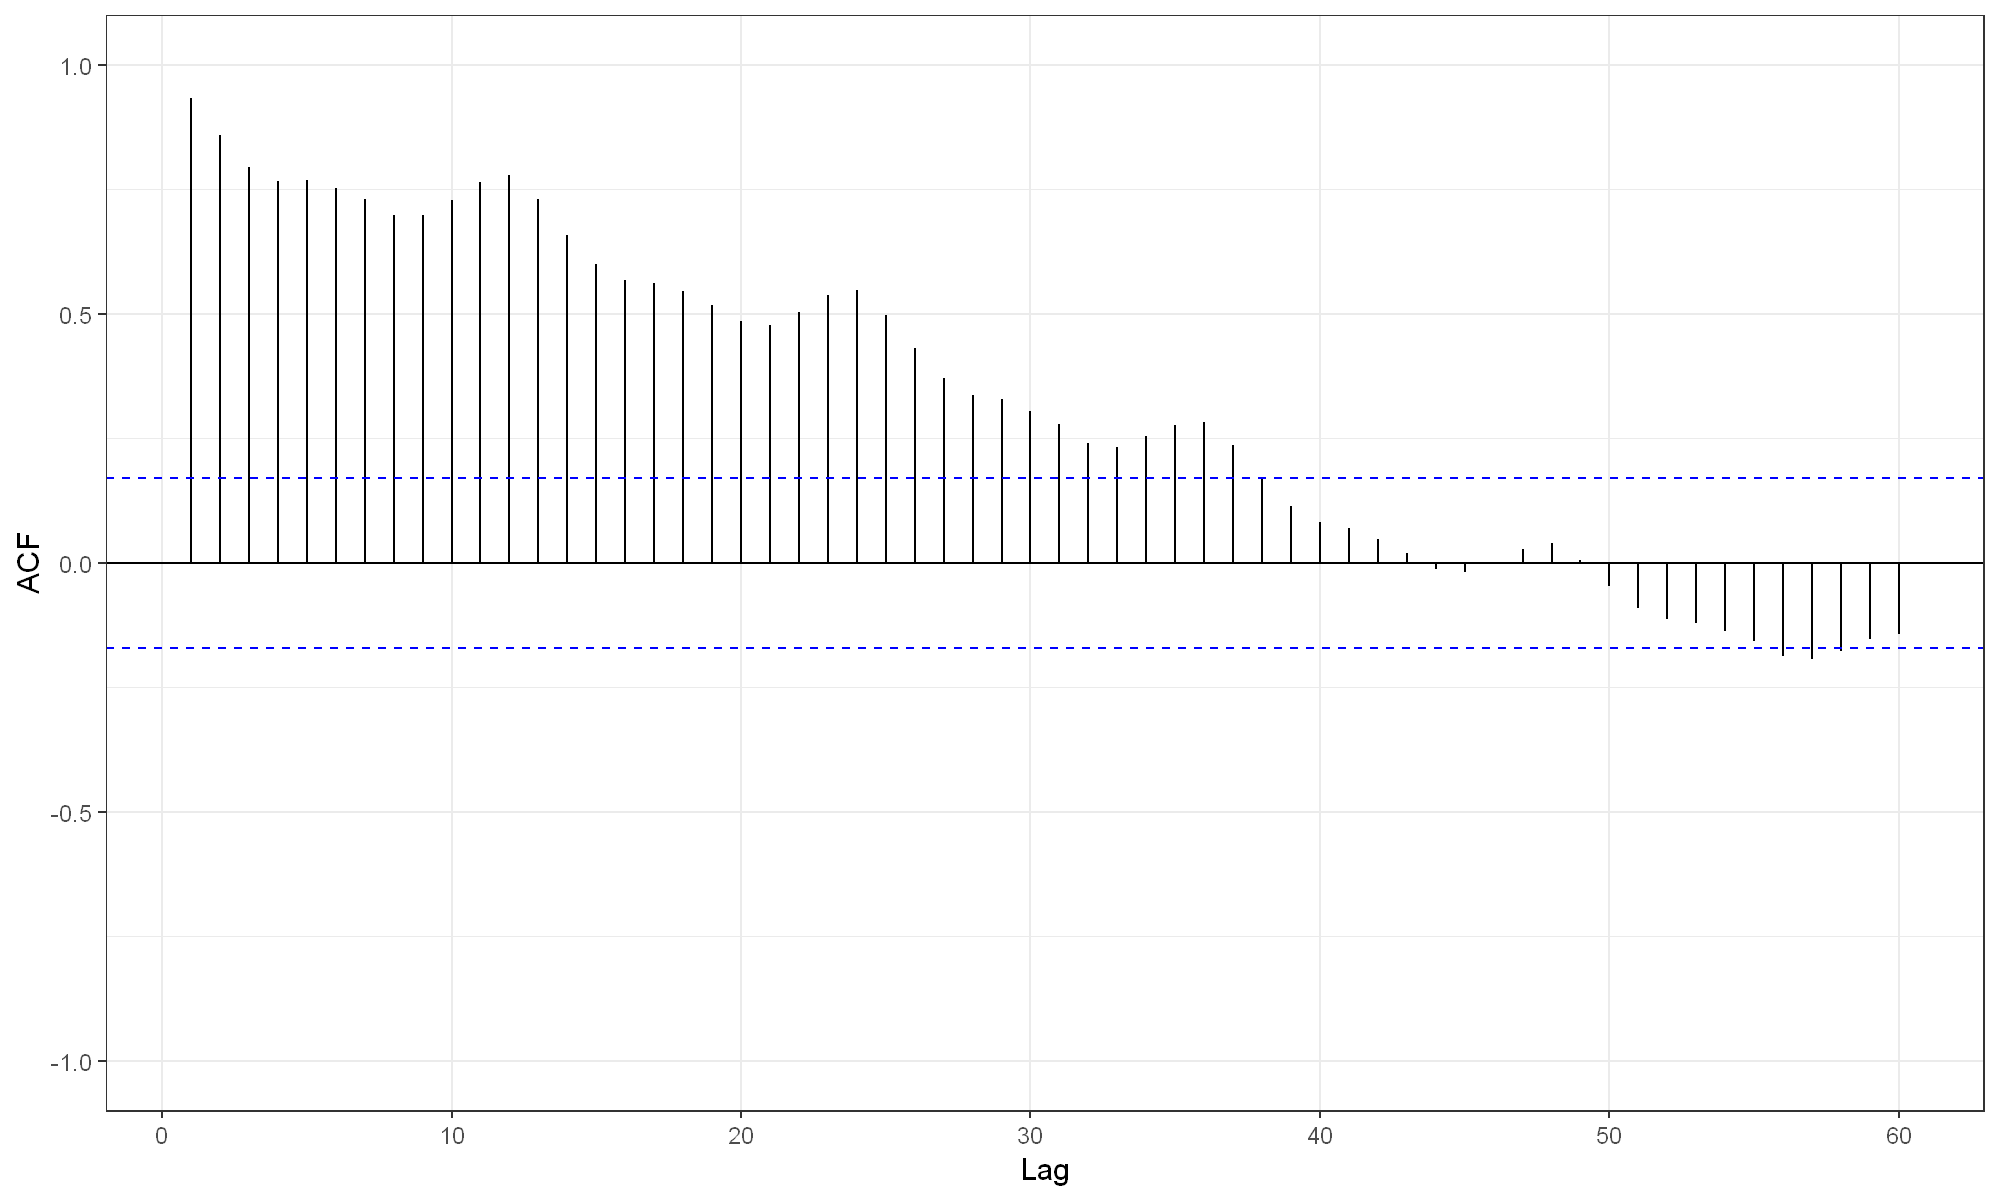

In [23]:
ggAcf(dt$lnz,lag.max = 60) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

* 지수적으로 감소하나 중강중간 올긋볼긋한 것이 보이는데 이것은 계절 차분이 필요한 특성임

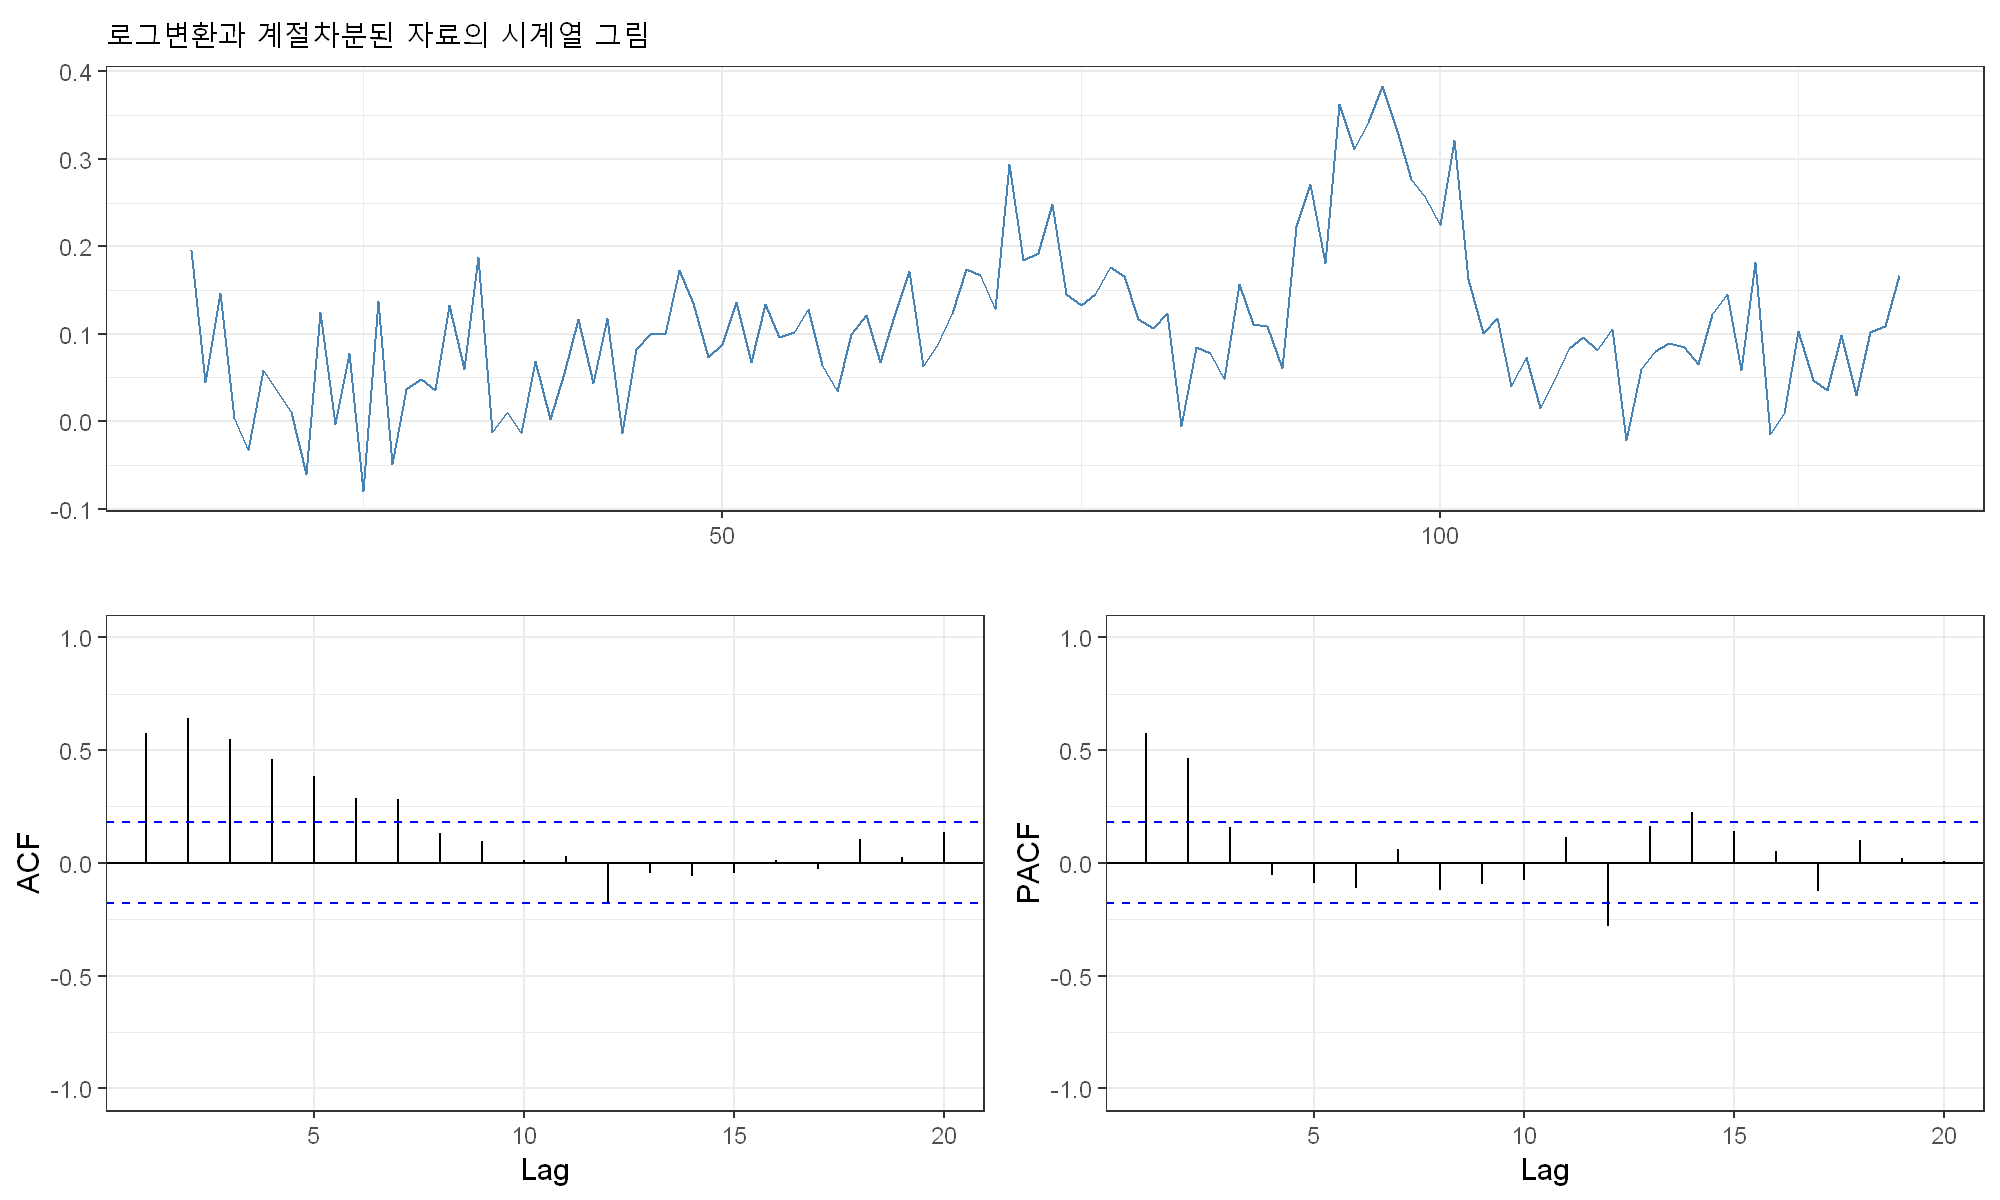

In [24]:
dt[, df12_lnz := c(rep(0,12), diff(lnz,12))]
sdt <- dt[-(1:12)]

p3 <- ggplot(sdt, aes(t, df12_lnz)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('로그변환과 계절차분된 자료의 시계열 그림')+
  theme_bw()

p1 <- ggAcf(sdt$df12_lnz) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(sdt$df12_lnz) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

* ACF의 경우 천천히 감소한다.
* 단위근 검정을 통해 검정

In [26]:
adfTest(sdt$df12_lnz, lags = 0, type = "c")
adfTest(sdt$df12_lnz, lags = 1, type = "c")
adfTest(sdt$df12_lnz, lags = 2, type = "c")

Warning message in adfTest(sdt$df12_lnz, lags = 0, type = "c"):
"p-value smaller than printed p-value"



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -5.6041
  P VALUE:
    0.01 

Description:
 Thu Dec 09 16:49:41 2021 by user: lee



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -2.9255
  P VALUE:
    0.04669 

Description:
 Thu Dec 09 16:49:41 2021 by user: lee



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -2.4004
  P VALUE:
    0.1661 

Description:
 Thu Dec 09 16:49:41 2021 by user: lee


* 검정결과 lag 2에서 단위근이 있다고 판단됨

### lag2에서 다시 차분

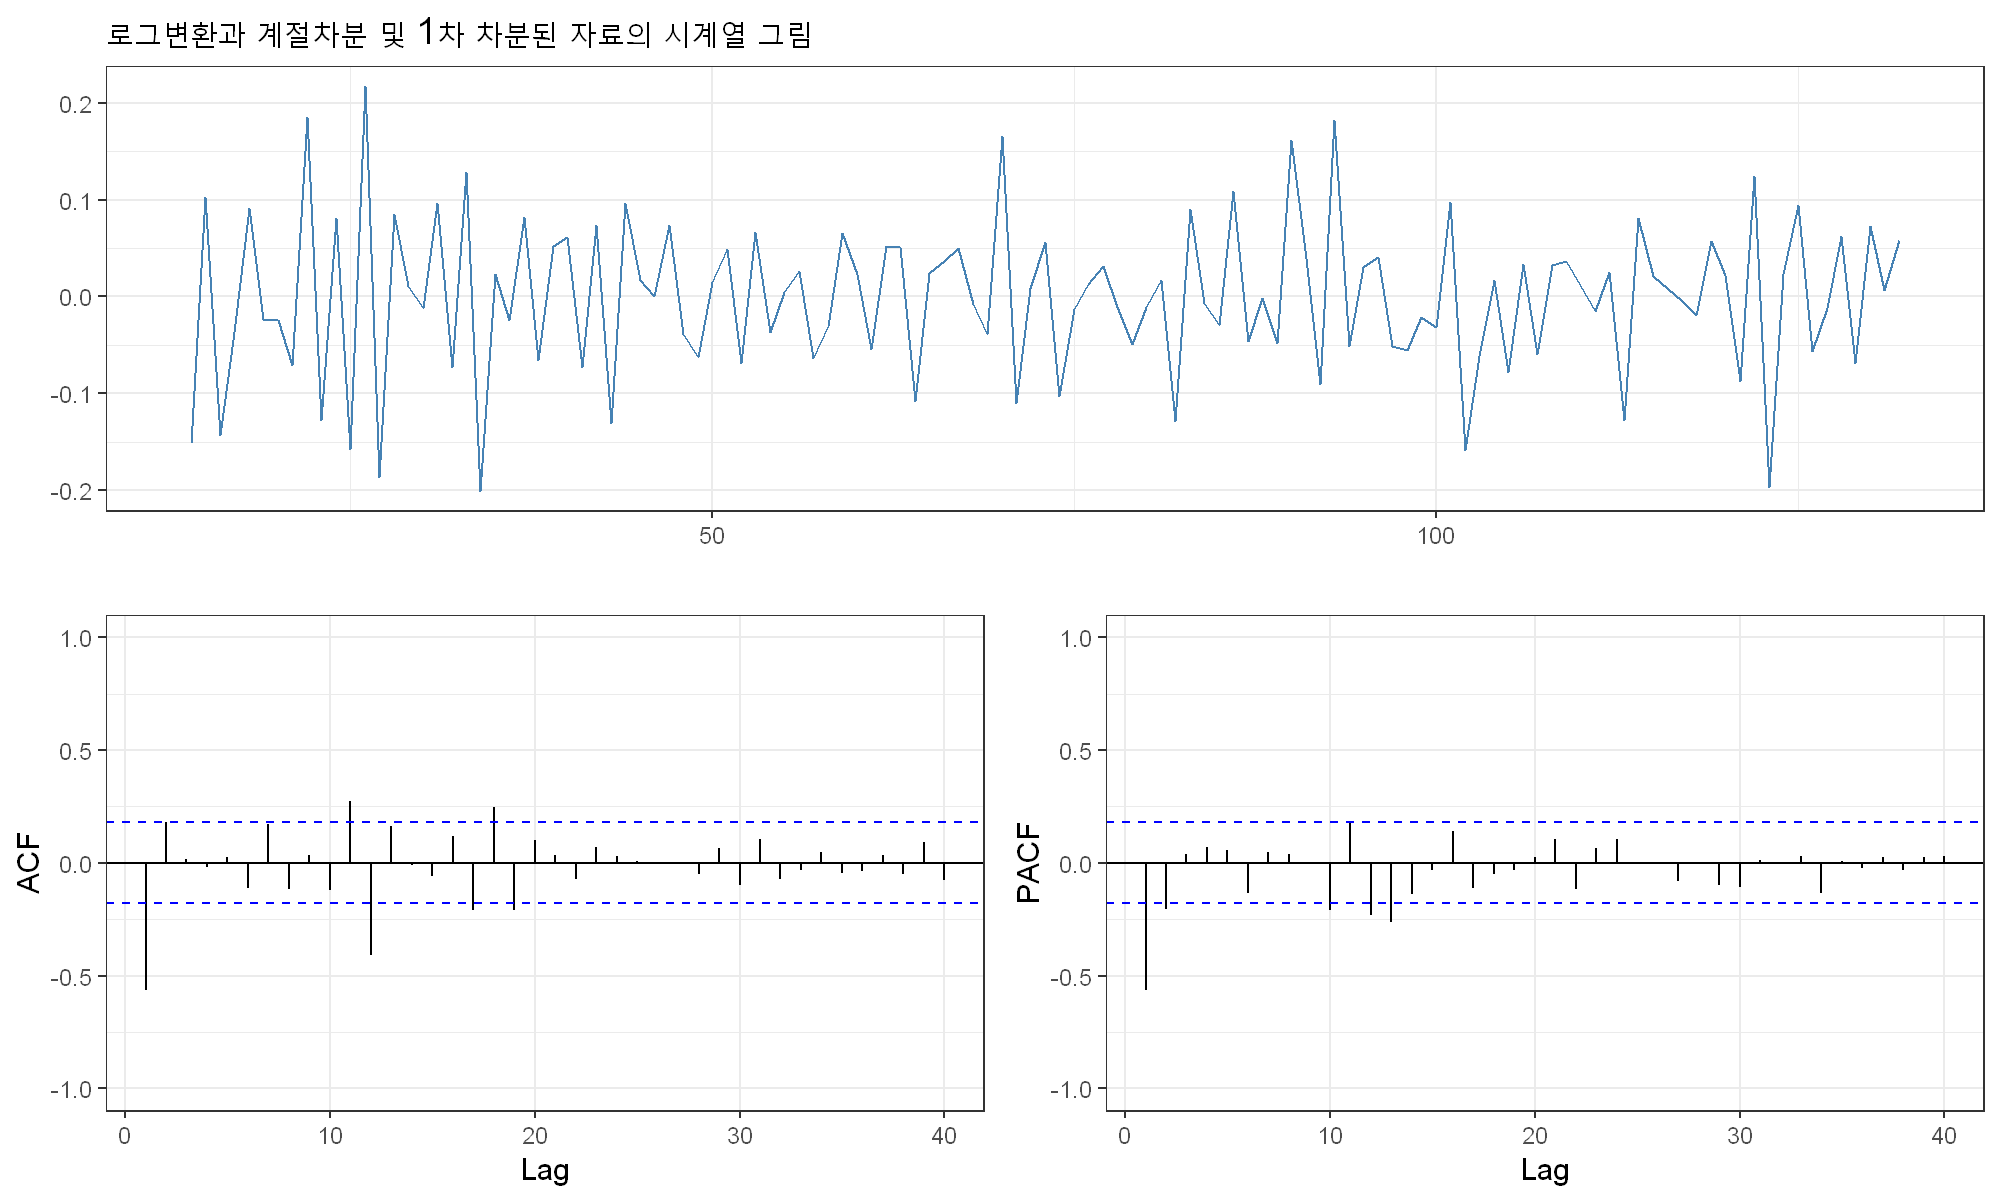

In [27]:
sdt[, df1_df12_lnz := c(0, diff(df12_lnz))]
ssdt <- sdt[-1,]

p3 <- ggplot(ssdt, aes(t, df1_df12_lnz)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('로그변환과 계절차분 및 1차 차분된 자료의 시계열 그림')+
  theme_bw()

p1 <- ggAcf(ssdt$df1_df12_lnz, lag.max = 40) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(ssdt$df1_df12_lnz, lag.max = 40) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))


* acf를 보면 MA(1), PACF를 보면 AR(1)을 고려헐 수 있다.

* 또한 lag 12 에서 각각 유의한 값을 보인다.

* acf를 보면 SMA(1), pacf를 보면 SAR(1) 모형을 고려해볼 수 있다. 

* 또한 저번시간에 배운 것처럼 $Arima(1,0,0)(1,0,0)_{12}$ 이런 경우 12시차에서 pacf값이 양쪽시차에서 유의한 경우를 간혹 볼 수 있다.

* 결론 : MA차수 p=1, sma 차수 =1 로 하여 모형을 적합시키겠다.(앞에서 계절차분 및 1차차분을 시행했음)
    * $\ln z \to ARIMA(0,1,1)(0,1,1)_{12}$모형을 적합시키겠다.(책에서 이렇게 했음.,.)

## 모형적합 𝐴𝑅𝐼𝑀𝐴(0,1,1)(0,1,1)_12 

In [31]:
fit1 = arima(dt$lnz, order = c(0,1,1), seasonal = list(order = c(0,1,1), 
                                                      period = 12))
fit1


Call:
arima(x = dt$lnz, order = c(0, 1, 1), seasonal = list(order = c(0, 1, 1), period = 12))

Coefficients:
          ma1     sma1
      -0.5800  -0.5525
s.e.   0.0698   0.0791

sigma^2 estimated as 0.003281:  log likelihood = 169.06,  aic = -332.13

### 잔차분석

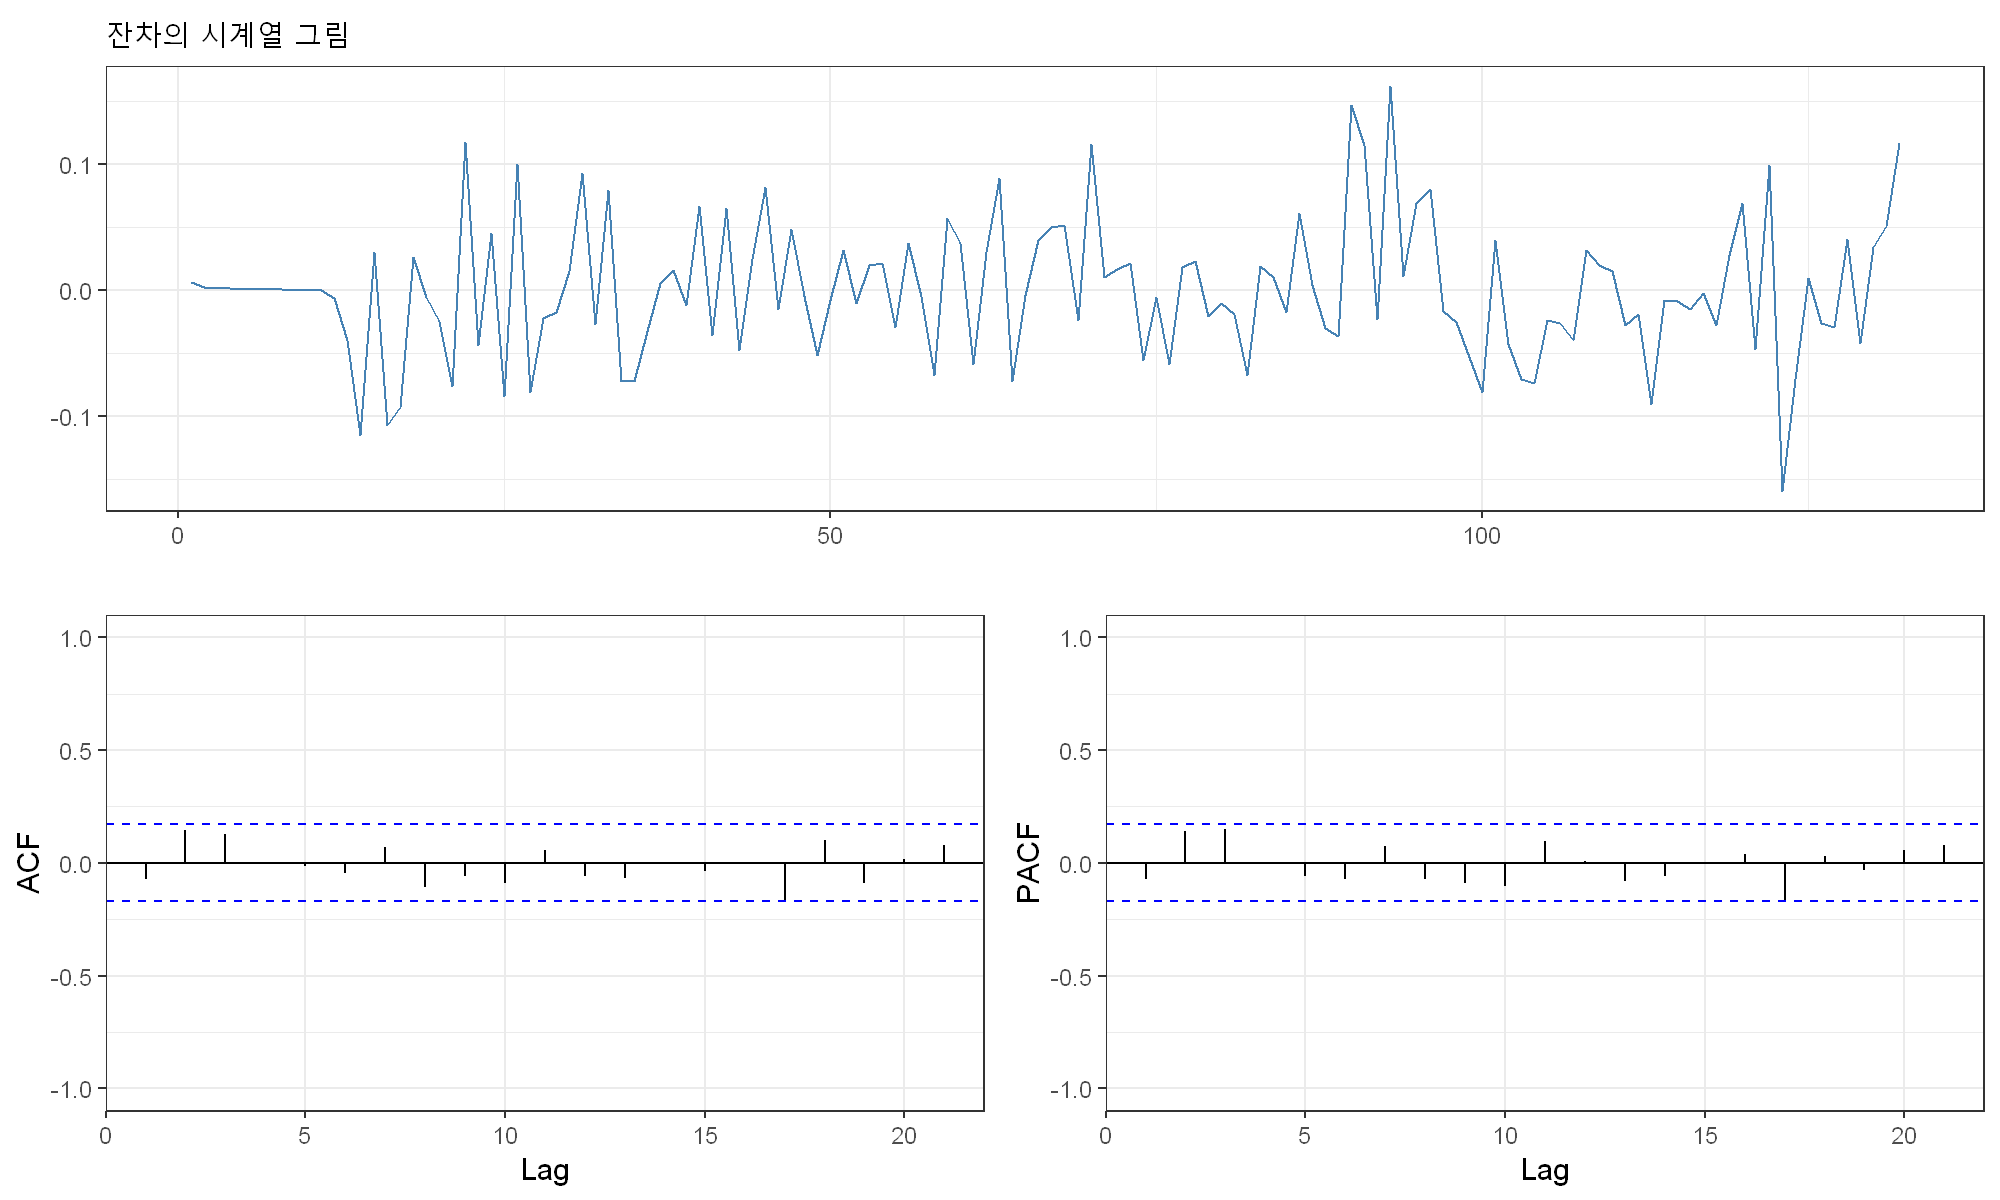

In [32]:
dt[, res := as.numeric(resid(fit1))]

p3 <- ggplot(dt, aes(t, res)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('잔차의 시계열 그림')+
  theme_bw()

p1 <- ggAcf(dt$res) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(dt$res) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

In [33]:
LjungBox(fit1, lags=seq(6,24,6))

,lags,statistic,df,p-value
,6,6.161299,4,0.1874219
,12,11.263183,10,0.3373847
,18,17.902458,16,0.3296397
,24,26.059604,22,0.2491317


## 모형적합  ARIMA(0,1,1)(1,1,0)_12

In [35]:
fit2 = arima(dt$lnz, order = c(0,1,1), 
             seasonal = list(order = c(1,1,0),  period = 12));  fit2


Call:
arima(x = dt$lnz, order = c(0, 1, 1), seasonal = list(order = c(1, 1, 0), period = 12))

Coefficients:
          ma1     sar1
      -0.6054  -0.5366
s.e.   0.0665   0.0810

sigma^2 estimated as 0.003276:  log likelihood = 169.28,  aic = -332.56

### 잔차분석

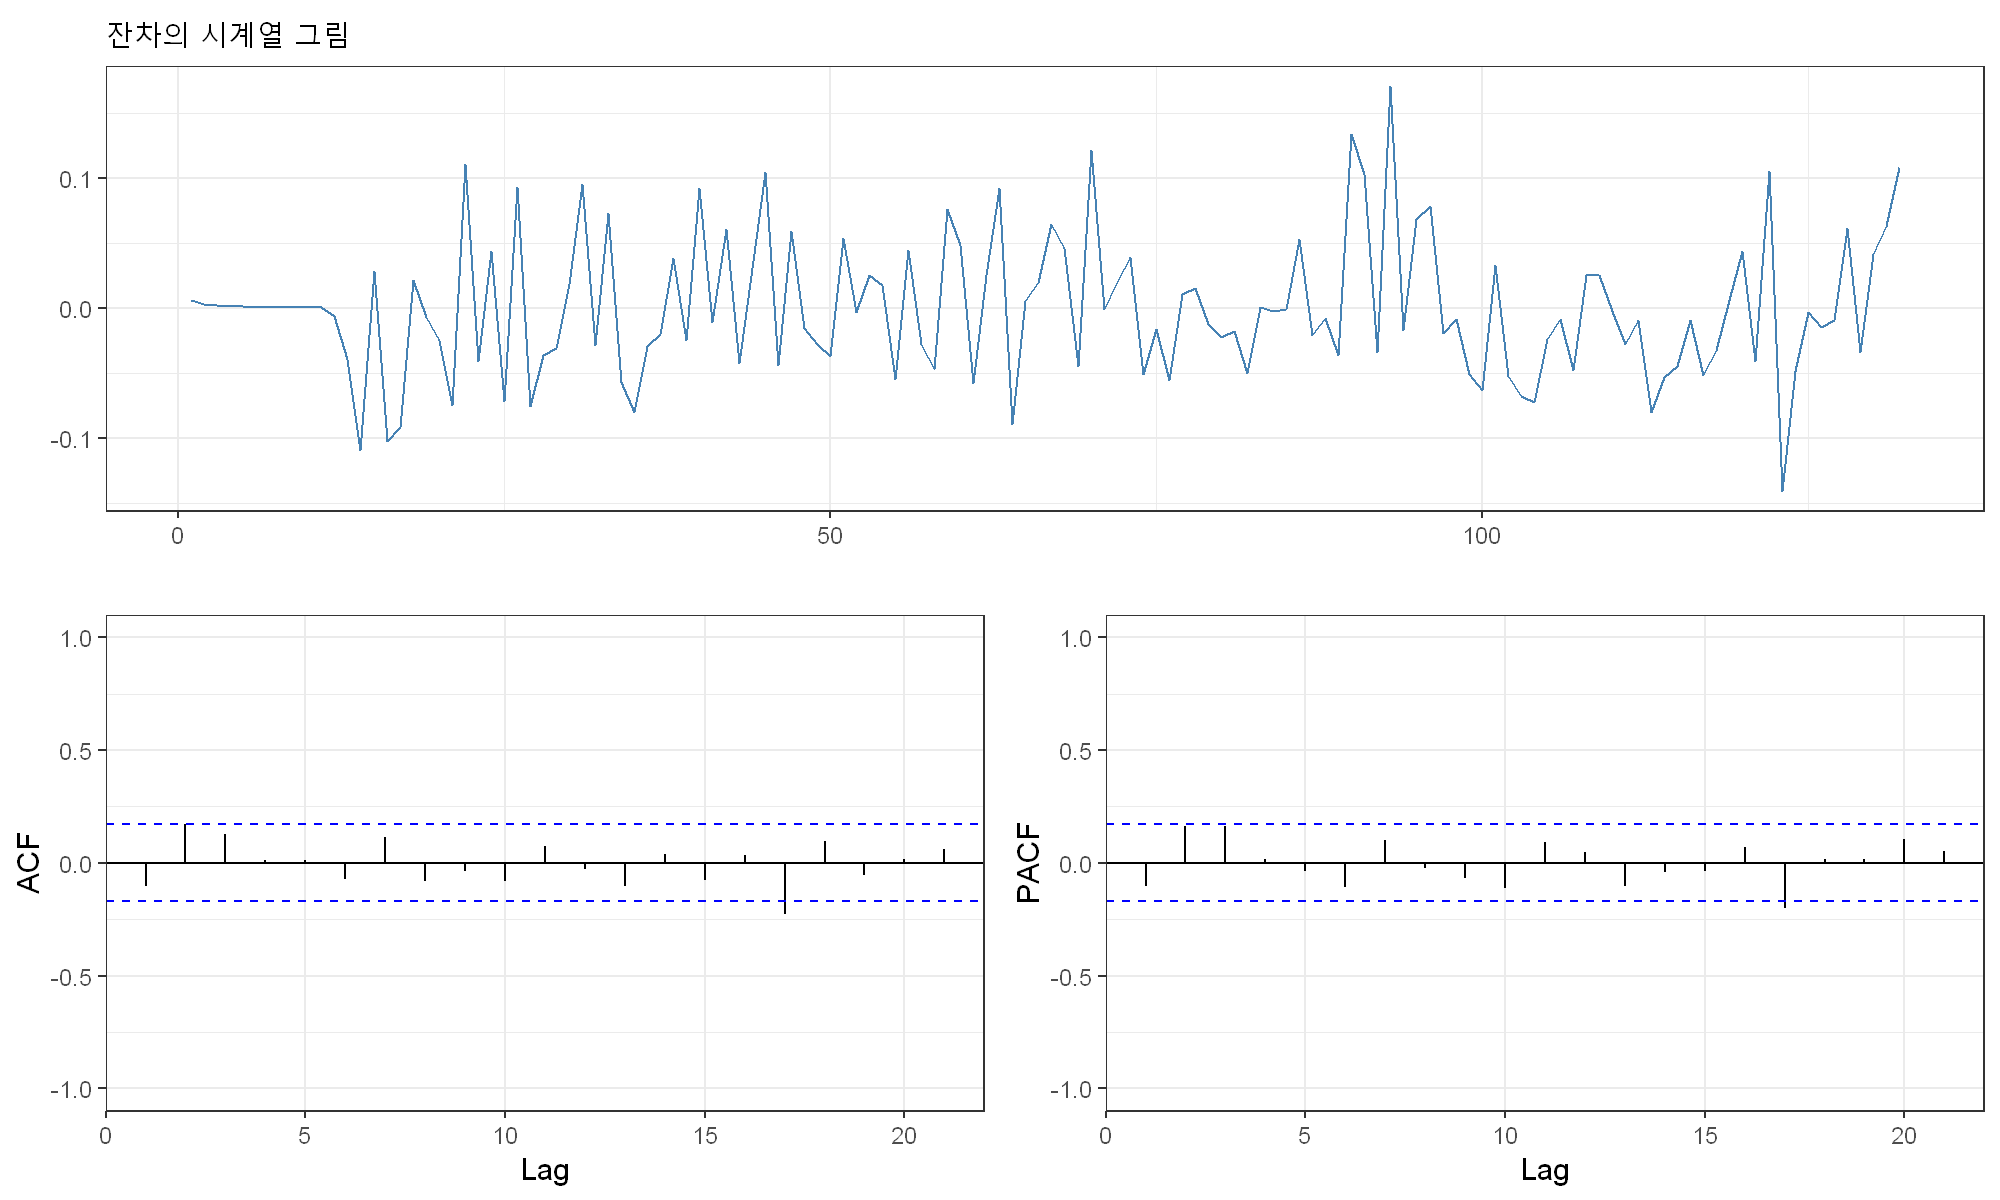

In [39]:
dt[, res2 := as.numeric(resid(fit2))]

p3 <- ggplot(dt, aes(t, res2)) + 
  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('잔차의 시계열 그림')+
  theme_bw()

p1 <- ggAcf(dt$res2) + 
  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(dt$res2) + 
  theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1),
                                   c(2,3)))

In [40]:
LjungBox(fit2, lags=seq(6,24,6))

,lags,statistic,df,p-value
,6,8.371571,4,0.07887711
,12,13.137631,10,0.21607822
,18,25.447443,16,0.06231600
,24,38.216710,22,0.01732204


* lag 18에서 잔차의 자기상관이 존재하다는 결론이 나옴

In [42]:
fit1;fit2


Call:
arima(x = dt$lnz, order = c(0, 1, 1), seasonal = list(order = c(0, 1, 1), period = 12))

Coefficients:
          ma1     sma1
      -0.5800  -0.5525
s.e.   0.0698   0.0791

sigma^2 estimated as 0.003281:  log likelihood = 169.06,  aic = -332.13


Call:
arima(x = dt$lnz, order = c(0, 1, 1), seasonal = list(order = c(1, 1, 0), period = 12))

Coefficients:
          ma1     sar1
      -0.6054  -0.5366
s.e.   0.0665   0.0810

sigma^2 estimated as 0.003276:  log likelihood = 169.28,  aic = -332.56

### 최종결정

* 잔차 검정시 문제가 없는 fit1을 쓰겠다고 결론을 내릴 수 있음

# auto.arima : in forecast

* 계절차분과 일반차분을 1번씩 한 데이터를 사용

In [47]:
auto.arima(ssdt$df1_df12_lnz)  

Series: ssdt$df1_df12_lnz 
ARIMA(2,0,0) with zero mean 

Coefficients:
          ar1      ar2
      -0.7016  -0.2128
s.e.   0.0902   0.0904

sigma^2 estimated as 0.00427:  log likelihood=156.55
AIC=-307.1   AICc=-306.89   BIC=-298.76

* 최종적으로 선택한 모형 :  $ARIMA(2,1,0)(0,1,0)_{12}$

In [48]:
auto.arima(ssdt$df1_df12_lnz, trace=T, ic='aic')


 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -256.2744
 ARIMA(1,0,0) with non-zero mean : -301.7002
 ARIMA(0,0,1) with non-zero mean : -298.6352
 ARIMA(0,0,0) with zero mean     : -258.2734
 ARIMA(2,0,0) with non-zero mean : -305.1014
 ARIMA(3,0,0) with non-zero mean : -303.1217
 ARIMA(2,0,1) with non-zero mean : -303.1156
 ARIMA(1,0,1) with non-zero mean : -304.21
 ARIMA(3,0,1) with non-zero mean : -301.2377
 ARIMA(2,0,0) with zero mean     : -307.1012
 ARIMA(1,0,0) with zero mean     : -303.7
 ARIMA(3,0,0) with zero mean     : -305.1216
 ARIMA(2,0,1) with zero mean     : -305.1155
 ARIMA(1,0,1) with zero mean     : -306.2097
 ARIMA(3,0,1) with zero mean     : -303.2374

 Best model: ARIMA(2,0,0) with zero mean     



Series: ssdt$df1_df12_lnz 
ARIMA(2,0,0) with zero mean 

Coefficients:
          ar1      ar2
      -0.7016  -0.2128
s.e.   0.0902   0.0904

sigma^2 estimated as 0.00427:  log likelihood=156.55
AIC=-307.1   AICc=-306.89   BIC=-298.76

### not auto.arima

In [50]:
fit3 = arima(ssdt$df1_df12_lnz, order = c(0,0,1), 
             seasonal = list(order = c(0,0,1),  period = 12))
fit3


Call:
arima(x = ssdt$df1_df12_lnz, order = c(0, 0, 1), seasonal = list(order = c(0, 
    0, 1), period = 12))

Coefficients:
          ma1     sma1  intercept
      -0.5822  -0.5574     0.0006
s.e.   0.0701   0.0798     0.0011

sigma^2 estimated as 0.003272:  log likelihood = 169.18,  aic = -330.37

* auto.arima를 쓰면 계절형 차수를 찾아주지 않음 즉 계절형 ARMA 모형을 고려할 수 없다는 것이다.

* 위 처럼 직접 모형을 적합한 경우의 AIC 값이 더 낮은 것을 알 수 있었다.심지어 mse(sigma^2 estimated)값도 더 낮앗음

* 즉 auto.arima 는 참고용으로 쓰자...